In [ ]:
'''!pip install pyvis
!pip install deap
!pip install pyvis
!pip install deap
!pip install python-igraph
!pip install leidenalg'''

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from pyvis.network import Network
from collections import Counter
from networkx.algorithms import community
import math
import random
import copy
import time
import statistics
from deap import creator , base , tools , algorithms

In [ ]:
G = nx.read_graphml('work/amazon_graph.graphml') #sustituir por el directorio donde se encentra el archivo del grafo
node_list = list(G.nodes())

In [ ]:
# Función que genera un genoma (codificación locus) para cada nodo basado en sus vecinos
def locus_adjacency_gen():
    encoding = []
    for node in node_list:
        neighbors = list(G.neighbors(node))
        if neighbors:
            neighbor = random.choice(neighbors)
            genotype = node_list.index(neighbor)
        else:
            genotype = node
        encoding.append(genotype)
    return encoding

# Función que encuentra comunidades en un individuo (codificación_locus) usando un enfoque de búsqueda en profundidad (DFS)
def locus2communities(ind):
    communities = []
    visited = set()

    # Función DFS interna para explorar las comunidades
    def dfs(node, current_community):
        visited.add(node)
        current_community.add(node)
        neighbor = ind[node]
        if neighbor not in visited:
            dfs(neighbor, current_community)
    for i in range(len(ind)):
        if i not in visited:
            current_community = set()
            dfs(i, current_community)

            merged = False
            for node in current_community:
                for j, community in enumerate(communities):
                    if node in community or ind[node] in community:
                        community.update(current_community)
                        merged = True
                        break
                if merged:
                    break
            if not merged:
                communities.append(current_community)
    return communities

# Función que obtiene el índice del vecino siguiente basado en la vecindad del nodo actual
def get_adjacency_node(node_index, current_neighbor):
    neighbors = list(G.neighbors(node_list[node_index]))
    if(len(neighbors) > 1):
        neighbor = random.choice(neighbors)
        while neighbor == node_list[current_neighbor]:
            neighbor = random.choice(neighbors)
        return node_list.index(neighbor)
    else:
        return current_neighbor

# Función que inicializa una población de individuos
def init_population(N=50):
    pop = []
    for _ in range(N):
        ind = locus_adjacency_gen()
        pop.append(ind)
    return pop

# Función que decodifica un genoma (codificación) en un grafo utilizando una lista de nodos
def decodificacion_locus_por_indices(genotype, node_list):
    G_decoded = nx.Graph()
    G_decoded.add_nodes_from(node_list)
    for idx, gene_idx in enumerate(genotype):
        node = node_list[idx]
        neighbor_node = node_list[gene_idx]
        G_decoded.add_edge(node, neighbor_node)
    return G_decoded

In [ ]:
# Función de crossover
def my_crossover(ind1, ind2, which = -1):
    global which_crossover

    if which == -1:
        which = which_crossover

    '''
    cxOnePoint: Realiza el crossover de un punto. Un punto de corte se selecciona aleatoriamente y los segmentos de los padres se intercambian en ese punto.

    cxTwoPoint: Realiza el crossover de dos puntos. Dos puntos de corte se seleccionan aleatoriamente y los segmentos intermedios de los padres se intercambian.

    cxUniform: Realiza el crossover uniforme. Para cada gen, se selecciona aleatoriamente uno de los padres para transmitir ese gen al descendiente.
    o crossover específico para algoritmos evolutivos (EA). Realiza el crossover discreto para estrategias de evolución (ES).
    '''

    if which == 0:
        return tools.cxOnePoint(ind1, ind2)
    if which == 1:
        return tools.cxTwoPoint(ind1, ind2)
    if which == 2:
        global crosspbp
        return tools.cxUniform(ind1, ind2, indpb=crosspbp)
    if which_crossover == 3:
        that_crossover = random.randint(0, 2)
        return my_crossover(ind1, ind2, that_crossover)

# Función de mutación
def my_mutation(ind):
    global mutpbp
    for i in range(len(ind)):
        my_rand = random.random()
        if my_rand < mutpbp:
            ind[i] = get_adjacency_node(i,ind[1])
    return ind,


In [ ]:
# Función que calcula la densidad interna total de las comunidades en un individuo
def internal_density_fit(ind):
    # Función objetivo a minimizar
    communities = locus2communities(ind)

    def calculate(G, c):
        real_nodes = [node_list[i] for i in c]

        if len(c) > 1:
            subgraph = G.subgraph(real_nodes)
            m_S = subgraph.number_of_edges()
            n_S = len(c)
            return 1-(m_S / (n_S * (n_S - 1) / 2))  # Densidad de una comunidad
        else:
            return 1000
    internal_density_tot = sum(calculate(G, community) for community in communities)
    return internal_density_tot

# Función que calcula el puntaje de la comunidad en un individuo
def community_score_fit(ind):
     # Función objetivo a maximizar
    score = 0
    communities = locus2communities(ind)
    for community in communities:
        real_nodes = [node_list[i] for i in community]
        subgraph = G.subgraph(real_nodes)
        m_S = subgraph.number_of_edges()  # Número de aristas dentro de la comunidad
        n_S = len(community)  # Número de nodos en la comunidad
        if n_S > 1:
            score += (2 * m_S / n_S) ** 2
    return score

f1 = internal_density_fit
f2 = community_score_fit

# Función de evaluación que devuelve los valores de las funciones objetivo
def my_evaluate(ind):
    return f1(ind), f2(ind)

# Función de selección por torneo
def seleccion_torneo(individuals, k, T=8):
    chosen = []
    for _ in range(k):
        tournament = random.sample(individuals, T)
        if random.random() < 0.5:
            winner = min(tournament, key=lambda ind: ind.fitness.values[0])
        else:
            winner = max(tournament, key=lambda ind: ind.fitness.values[1])
        chosen.append(winner)
    return chosen


In [ ]:
#creator.create("FitnessMaxMax", base.Fitness, weights=(1.0,1.0))
#creator.create("FitnessMinMin", base.Fitness, weights=(-1.0,-1.0))
creator.create("FitnessMinMax", base.Fitness, weights=(-1.0,1.0))


creator.create("Individual", list, typecode='d', fitness=creator.FitnessMinMax)

toolbox = base.Toolbox()
'''
toolbox.register("indices", np.random.permutation, len(node_list))
toolbox.register("Individual", tools.initIterate, creator.Individual, toolbox.indices)
'''

toolbox.register("individual", tools.initIterate, creator.Individual, locus_adjacency_gen)


toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", my_evaluate)
toolbox.register("mate", my_crossover)
toolbox.register("mutate", my_mutation)

toolbox.register("select", tools.selNSGA2)

In [ ]:
stats = tools.Statistics(lambda ind: ind.fitness.values)

stats.register("avg", lambda fits: tuple(sum(fit) / len(fits) for fit in zip(*fits)))
stats.register("max", lambda fits: tuple(max(fit) for fit in zip(*fits)))
stats.register("min", lambda fits: tuple(min(fit) for fit in zip(*fits)))
stats.register("std", lambda fits: np.std(fits))

def staticts2str(record,len_pareto_front, gen):
    log_str = f"Gen: {gen}, " \
              f"Avg: {record['avg']}, " \
              f"Max: {record['max']}, " \
              f"Min: {record['min']}, " \
              f"Std: {record['std']}, " \
              f"Size of Pareto Front: {len_pareto_front}"
    return log_str

In [ ]:
logbook = tools.Logbook()
logbook.header = ["gen", "avg", "max", "min", "std", "size_of_pareto_front"]

In [ ]:
# Función que desempaqueta el frente de Pareto, convirtiéndolo en una lista de individuos.
def pareto_font_unzip(pareto_font):
    inds = []
    for individuo in pareto_font:
        inds.append(individuo)
    return inds

In [ ]:
# Función que calcula y muestra estadísticas de una población dada.
def statcs_pop(population):
    fits = toolbox.map(toolbox.evaluate, population)
    init_internal_density, init_community_score  = list(zip(*fits))

    max_init_internal_density = max(init_internal_density)
    min_init_internal_density = min(init_internal_density)
    mean_init_internal_density = statistics.mean(init_internal_density)
    stdev_init_internal_density = statistics.stdev(init_internal_density)

    max_init_community_score = max(init_community_score)
    min_init_community_score = min(init_community_score)
    mean_init_community_score = statistics.mean(init_community_score)
    stdev_init_community_score = statistics.stdev(init_community_score)


    print(f"max: ({max_init_internal_density},{max_init_community_score})")
    print(f"min: ({min_init_internal_density},{min_init_community_score})")
    print(f"mean: ({mean_init_internal_density},{mean_init_community_score})")
    print(f"stdev: ({stdev_init_internal_density},{stdev_init_community_score})")

In [ ]:
# Función que visualiza el frente de Pareto en un gráfico de dispersión.
def paint_pareto_front(pop):
    fronts = tools.sortNondominated(pop, len(pop), first_front_only=False)
    colors = [
    "red", "blue", "green", "orange", "purple", "cyan",
    "magenta", "lime", "teal", "coral", "navy", "fuchsia",
    "maroon", "olive", "chocolate", "darkgreen", "darkblue",
    "crimson", "darkslateblue", "darkcyan", "darkmagenta",
    "darkolivegreen", "darkorange", "darkorchid", "darkred",
    "darksalmon", "darkseagreen", "darkslategray", "darkturquoise",
    "darkviolet", "deepskyblue", "firebrick", "forestgreen",
    "indigo", "midnightblue", "royalblue", "saddlebrown",
    "sienna", "slateblue", "slategray", "steelblue",
    "tomato", "cadetblue"]

    for i, frente in enumerate(fronts):
        if i < len(colors):  # Evita un error si hay más frentes que colores definidos
            objetivo1 = [ind.fitness.values[0] for ind in frente]
            objetivo2 = [ind.fitness.values[1] for ind in frente]
            plt.scatter(objetivo1, objetivo2, color=colors[i], label=f"Front {i+1}")
    # Etiquetas y leyenda
    plt.xlabel("Objetivo 1")
    plt.ylabel("Objetivo 2")
    plt.title("Frentes de Pareto en NSGA-II")
    plt.legend()
    plt.grid(True)
    plt.show()
    print("Valores de fitness para los individuos en la primera capa del frente:")
    frontsF = tools.sortNondominated(pop, len(pop), first_front_only=True)
    print(f"funcion pareto front len: {len(frontsF[0])}")
    for ind in frontsF[0]:
        print(ind.fitness.values)

In [ ]:
# Función de evolución
def evolve(pop, ngen, current_round):
    pareto_front = tools.ParetoFront()
    #hof = tools.HallOfFame(1)
    statcs_pop(pop)
    for gen in range(ngen):
        print(f"generacion: {gen}")
        pop_seleccted = seleccion_torneo(pop, 50)
        offspring = algorithms.varAnd(pop_seleccted, toolbox, cxpb=0.5, mutpb=0.2)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
            ind.my_gen = gen
            ind.my_current_round = current_round

        print(f"len offspring: {len(offspring)}")

        offspring.extend(pareto_front)
        new_pop = toolbox.select(offspring, k=len(pop))
        print(f"LONGITUD DE NEW POP ES: . {len(new_pop)}")
        pop = new_pop
        #paint_pareto_front(pop)
        record = stats.compile(pop)
        pareto_front.update(pop)
        print(f"pareto front len: {len(pareto_front)}")

        print(staticts2str(record,len(pareto_front),gen))
        #hof.update(pop)
        logbook.record(gen=gen, size_of_pareto_front=len(pareto_front), **record)
    paint_pareto_front(pop)
    pareto_fronts.append(pareto_front)
    return pareto_front

In [ ]:
population = toolbox.population(n=50)
NGEN = 1000
fits = toolbox.map(toolbox.evaluate, population)
for fit, ind in zip(fits, population):
    ind.fitness.values = fit
print(population[0])

[154, 273, 357, 436, 261, 445, 402, 379, 395, 2, 117, 386, 464, 321, 268, 268, 253, 419, 458, 137, 418, 430, 104, 33, 215, 426, 311, 175, 463, 184, 387, 35, 357, 402, 197, 335, 357, 211, 301, 151, 386, 133, 289, 188, 396, 415, 285, 357, 287, 124, 397, 135, 165, 108, 66, 221, 258, 5, 265, 363, 359, 65, 319, 258, 286, 61, 54, 283, 149, 137, 56, 474, 442, 301, 301, 25, 301, 180, 150, 67, 146, 146, 418, 371, 342, 240, 91, 157, 363, 474, 473, 151, 8, 178, 261, 84, 415, 181, 285, 357, 315, 303, 338, 70, 413, 260, 471, 290, 435, 191, 359, 120, 25, 156, 315, 378, 64, 10, 405, 438, 259, 86, 30, 474, 376, 273, 205, 377, 258, 260, 446, 108, 282, 376, 408, 420, 166, 424, 196, 20, 64, 255, 461, 260, 350, 64, 430, 9, 414, 376, 166, 252, 163, 7, 430, 335, 283, 333, 443, 362, 402, 342, 450, 324, 357, 434, 283, 311, 212, 64, 84, 213, 417, 98, 389, 448, 114, 328, 315, 95, 179, 411, 146, 150, 29, 448, 376, 333, 281, 13, 99, 109, 191, 425, 297, 424, 35, 410, 315, 210, 151, 97, 441, 361, 402, 436, 75, 408,

==== INICIO (mutpbp: 0.37872349364142033 - crosspbp: 0.8882320517841339 - crossover: 0
max: (27.673570383864508,618.6441153184406)
min: (21.179284707148607,449.96076218713677)
mean: (24.36346645920777,547.1693316560016)
stdev: (1.6487848265630844,34.80870756234831)
generacion: 0
len offspring: 50
LONGITUD DE NEW POP ES: . 50
pareto front len: 5
Gen: 0, Avg: (22.831614239510092, 544.8160520326579), Max: (27.68476916857634, 614.0818971887996), Min: (19.900587427240986, 440.78329815124863), Std: 262.7706053013365, Size of Pareto Front: 5
generacion: 1
len offspring: 50
LONGITUD DE NEW POP ES: . 50
pareto front len: 7
Gen: 1, Avg: (21.995616540510422, 552.6423972295188), Max: (26.13844932844933, 641.9746223894443), Min: (18.889331660375486, 449.3862927820139), Std: 266.67135088979154, Size of Pareto Front: 7
generacion: 2
len offspring: 50
LONGITUD DE NEW POP ES: . 50
pareto front len: 12
Gen: 2, Avg: (21.222661762743158, 563.1262228833571), Max: (25.034890062899212, 658.1471143563189), Mi

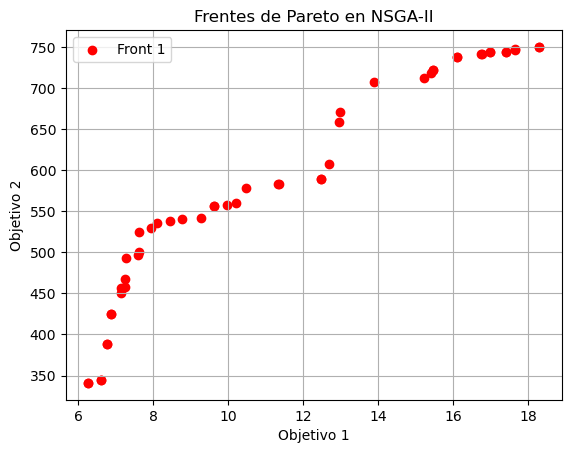

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(18.300856557769123, 750.0662373208494)
(18.300856557769123, 750.0662373208494)
(6.279624141285258, 341.04499847661185)
(6.279624141285258, 341.04499847661185)
(13.879814106754779, 707.2907599748997)
(12.68375169238019, 607.6283506260683)
(12.984307224130577, 671.0129400013849)
(12.971897125977904, 658.8590303749986)
(15.21293799796122, 711.7923609709225)
(10.478537029424297, 577.8427951243307)
(6.612677506531038, 344.9363520221453)
(6.612677506531038, 344.9363520221453)
(6.764427418268102, 388.7841341797902)
(6.764427418268102, 388.7841341797902)
(9.28144396165315, 542.0227212492313)
(11.35068804892096, 583.0784564821848)
(12.478009610870915, 589.6004968288925)
(12.478009610870915, 589.6004968288925)
(6.893221433287487, 425.3450728278822)
(6.893221433287487, 425.3450728278822)
(7.270276279551747, 493.3390548147109)
(7.6258029216277325, 525.19968457134)
(7.146027349434804, 450.63164530426

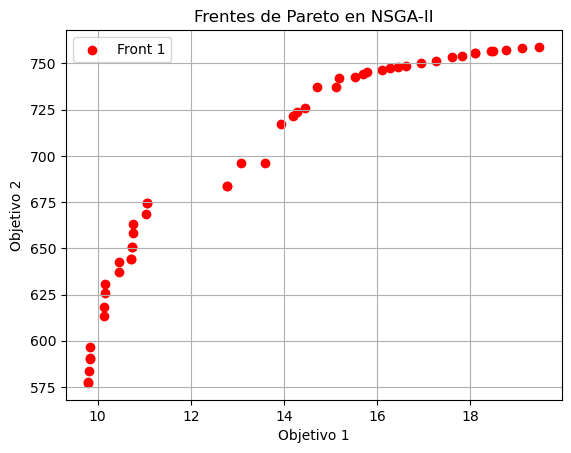

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(19.49205980800408, 758.9380498939181)
(9.799193748975616, 577.1796306332735)
(11.051526946245827, 674.7314992955236)
(11.051526946245827, 674.7314992955236)
(12.769733228455543, 683.6021633355513)
(12.769733228455543, 683.6021633355513)
(13.590591323390617, 696.3447924773025)
(13.928318176394253, 717.4784250871778)
(13.083049422427488, 696.1594174620932)
(10.129291674669643, 613.1631650805903)
(14.70546548722646, 737.0444515234994)
(9.829788756456807, 596.5032673936627)
(11.046134789383084, 668.6221242955237)
(10.452770636880679, 636.9690563744068)
(14.462547535280057, 726.1186776008434)
(15.121451826269345, 737.353591595371)
(10.746960754171088, 658.3811188844226)
(15.193804000292664, 742.2031114422623)
(18.779080842564692, 757.326175921923)
(14.203573176305698, 721.6471128408172)
(10.15989415830134, 630.9268785047739)
(15.529578567141282, 742.8377051192913)
(10.752658398063778, 663.330

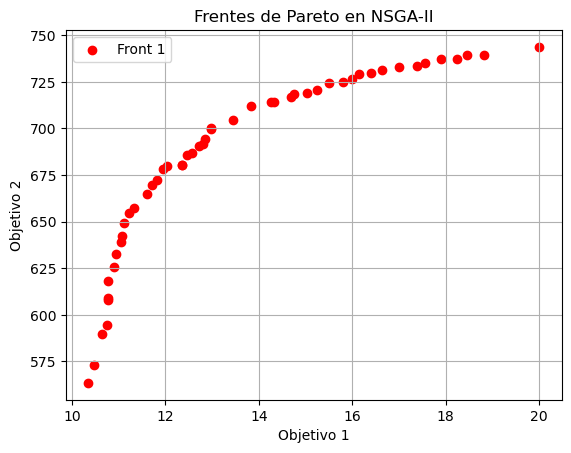

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(10.351514004455183, 563.505594738883)
(20.002922328216446, 743.7186882257328)
(13.453459367390659, 704.5504039290008)
(13.825862483622512, 712.2381086972567)
(12.981463040065346, 700.4555093974476)
(10.749069064550863, 594.6598062213935)
(10.765405015405015, 607.8470524045939)
(14.252435913232878, 714.3287486002026)
(12.854659294755509, 694.2450730198542)
(12.041450717972216, 679.7943734552284)
(10.769899863342488, 609.0720882044284)
(10.778150113444232, 618.2845524045939)
(14.325265044885537, 714.4379421550756)
(14.679344729463727, 716.955719070102)
(16.406417057610152, 729.643498972577)
(15.49675799637849, 724.5413392667144)
(15.245910490877709, 720.6515472636296)
(11.07783664585394, 642.5613811200807)
(12.968232248857493, 699.506608556679)
(14.747115825683686, 718.4198548631788)
(18.44606609568659, 739.1742107365823)
(10.936880272174388, 632.5345524045939)
(11.113120698414814, 649.535

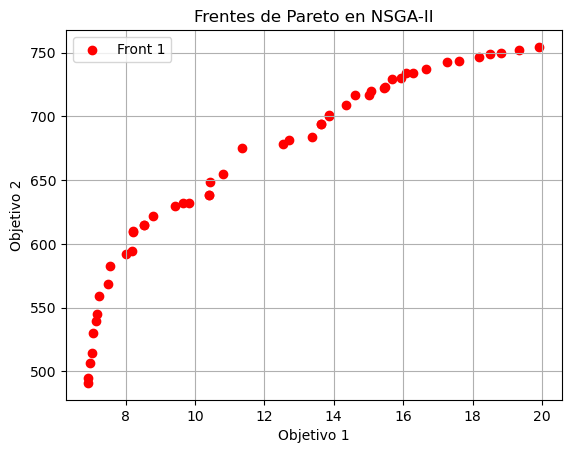

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(19.92552963032839, 754.5404012588717)
(6.927770575957734, 490.9485472127566)
(11.344804529561156, 675.2570456137994)
(10.810907170716916, 654.8254192575185)
(12.522037723859587, 678.0875488233323)
(8.783208455465427, 621.5646157536603)
(13.361215007369058, 683.9780100137475)
(9.419865361101579, 629.530840156251)
(10.436531204735052, 648.9603116053005)
(14.342499321094177, 708.75072001577)
(12.695391740448299, 681.4381074384419)
(9.837971194555823, 632.1636170619446)
(10.405607773719227, 638.5533646150293)
(10.405607773719227, 638.5533646150293)
(13.868087855226214, 701.0328883539577)
(14.60222826317606, 716.5577812435453)
(8.174622214392594, 594.5926159572625)
(7.181217665429187, 544.9272231560135)
(8.222195399730465, 609.5409524254919)
(7.505679709744282, 568.7131538400442)
(13.64391203105039, 693.8288067213045)
(13.64391203105039, 693.8288067213045)
(7.2286946692338265, 559.23759593609

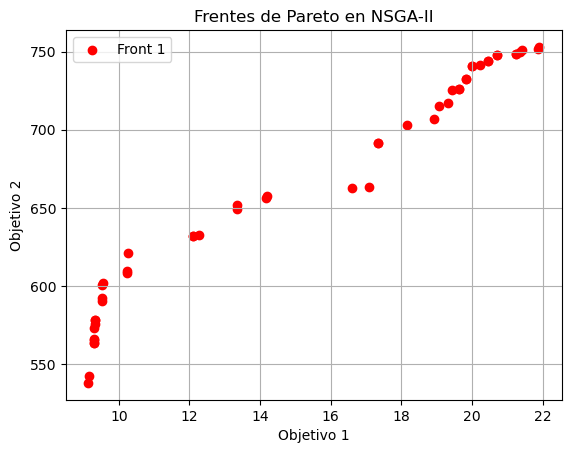

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(21.91062672389904, 753.0374164415289)
(9.137571117879823, 537.8330343476281)
(16.591396286143546, 662.6775143653546)
(10.25686410448121, 620.7603296291361)
(14.201803574249398, 657.7483518777176)
(12.100236372539841, 632.0340844614725)
(12.100236372539841, 632.0340844614725)
(18.173425826415006, 702.7136963235558)
(17.074463777647566, 663.185241062573)
(12.267607473037573, 632.6691155069886)
(13.344186495221908, 649.1304041265015)
(17.33434453709446, 691.7199625320708)
(17.33434453709446, 691.7199625320708)
(18.91370616791648, 707.0803695186202)
(9.282893911028703, 563.2325879694278)
(9.282893911028703, 563.2325879694278)
(9.160349569674683, 542.0544415121929)
(13.354312074674928, 651.7854695160504)
(14.167370135468742, 656.1236734727984)
(9.542101379456733, 601.9760380276683)
(10.227541865857729, 608.1417391137586)
(19.059116313326626, 714.983178790477)
(19.33283090283069, 717.363601966

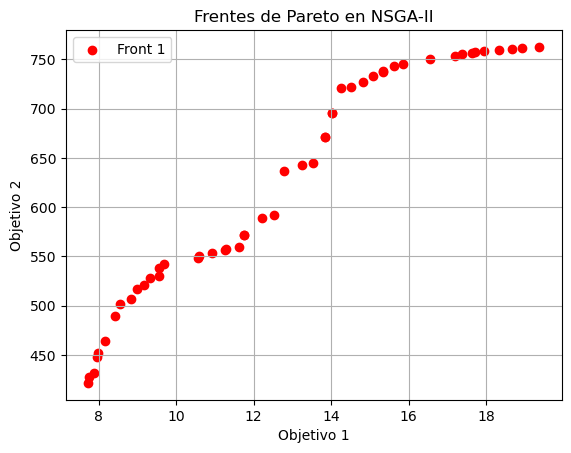

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(19.374510532566802, 762.7551045828602)
(7.7299874459481055, 421.5075149916996)
(12.784989198469601, 636.2936235712414)
(12.533122367652425, 592.315551611604)
(13.534494707657494, 644.4980173170317)
(12.207891071961418, 589.4629576688822)
(8.150513010855018, 464.03077228735077)
(8.40563427014467, 489.402161752057)
(14.260372979028443, 720.9308399997061)
(9.67808916207549, 542.2530614667619)
(13.841570943676208, 670.7937308751441)
(13.841570943676208, 670.7937308751441)
(14.027639443681425, 695.7186311390763)
(14.027639443681425, 695.7186311390763)
(11.740610155152234, 571.3000063700989)
(11.740610155152234, 571.3000063700989)
(10.55898845991085, 547.9081733883135)
(13.251157198706347, 642.9342204381923)
(11.618208673382513, 559.2062034019707)
(10.918675860369719, 553.922127207691)
(14.499742059994166, 722.5328779463597)
(8.550955137490643, 501.24000837867806)
(17.933426871655556, 759.0753

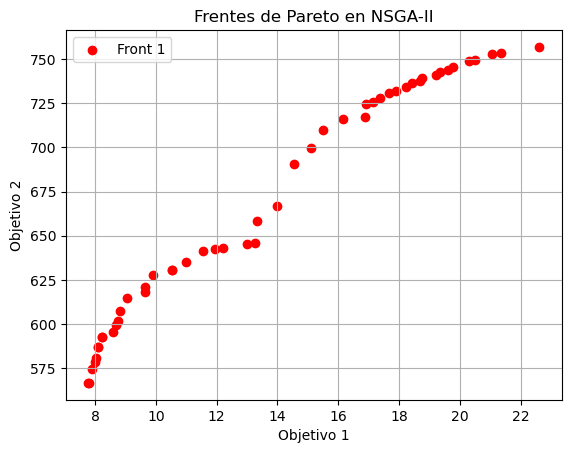

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(7.779998941429803, 566.5858555572026)
(22.617939689928594, 756.9645102683091)
(13.968658789251434, 667.0354383797115)
(14.546540749916037, 690.4610571282452)
(15.108466780990002, 699.7570268119358)
(13.332385719892562, 658.4345987812485)
(15.512030410250222, 709.6751696873721)
(16.16580937742034, 715.9239800033757)
(11.002118041829005, 635.0518179962374)
(9.892451557523026, 627.8886704537193)
(11.535791490773407, 641.1074802110629)
(16.871218355251813, 717.3082035050642)
(13.266915036100094, 645.9073285414212)
(12.2075922073825, 643.1690692862045)
(12.991520590962022, 645.2832929454653)
(9.054227778658756, 614.4407869259635)
(9.642912233090001, 621.0438498986163)
(17.382664212720666, 727.7930460106345)
(10.53307737240976, 630.721858292298)
(10.53307737240976, 630.721858292298)
(9.627028092099561, 617.8258350495852)
(11.93531822048708, 642.2269030384398)
(7.78275583366038, 566.61431360708

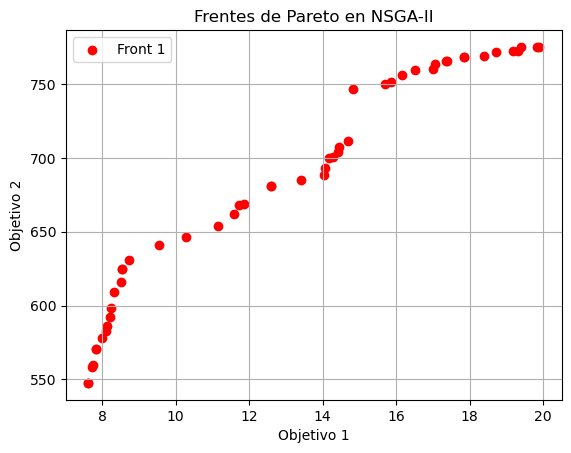

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(19.898308129778716, 775.2322382642357)
(7.627098389331671, 547.5981896349056)
(7.627098389331671, 547.5981896349056)
(14.821281697151584, 746.4274989302405)
(14.699942433803132, 711.2387798019672)
(9.556430550594394, 640.8131480399691)
(10.27528781324716, 646.1567877902091)
(11.140231042044418, 653.9174849137835)
(8.720914945894252, 631.0465674844136)
(13.41962729912789, 685.3544377287001)
(12.595819884709387, 681.0936059053915)
(11.872314393221552, 668.8037422960285)
(11.583966790003943, 661.9833427551916)
(15.705921962249537, 749.9051148183576)
(14.047385049966286, 688.3898245557679)
(12.606794091966586, 681.3433801868878)
(18.38750660076367, 768.9587201733657)
(14.067437436010975, 692.9807058933527)
(19.398308129778716, 774.9822382642357)
(7.714760726994009, 558.2856896349056)
(8.24677330862148, 598.5576037929777)
(8.334435646283817, 609.2451037929777)
(7.7449250071582885, 559.9501674

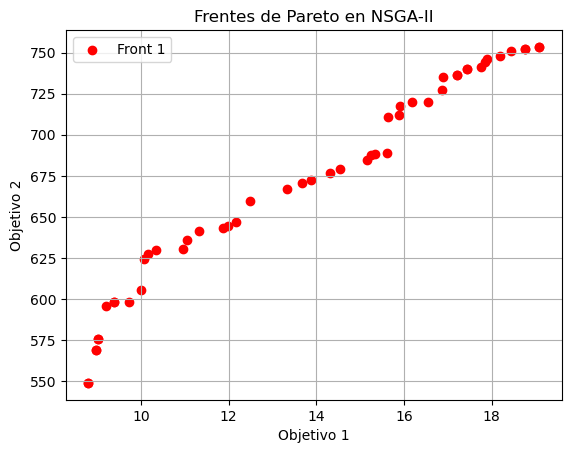

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(8.802467499462129, 549.0402708644559)
(8.802467499462129, 549.0402708644559)
(19.084343983401308, 753.4478988453151)
(19.084343983401308, 753.4478988453151)
(12.49383767984841, 660.0025000116474)
(13.336045468265226, 667.098950266644)
(15.629759236331743, 710.7893198911765)
(15.604007886427864, 689.1045180824603)
(14.545640070343971, 679.4158086290597)
(11.32801587301587, 641.5070516817838)
(9.196834135005235, 595.8296107485577)
(9.013765351936451, 575.8502708644559)
(9.013765351936451, 575.8502708644559)
(8.98553628253091, 569.0196107485577)
(8.98553628253091, 569.0196107485577)
(9.98986507790871, 605.7345805926042)
(15.156416588692812, 684.5003373112784)
(16.857258586557165, 727.1641268408168)
(16.53379891594169, 720.1537987118002)
(10.065543521329088, 624.6492740454275)
(14.309614619986139, 676.8677020337686)
(12.172415783450264, 647.0618848349502)
(13.883676120622816, 672.75551620086

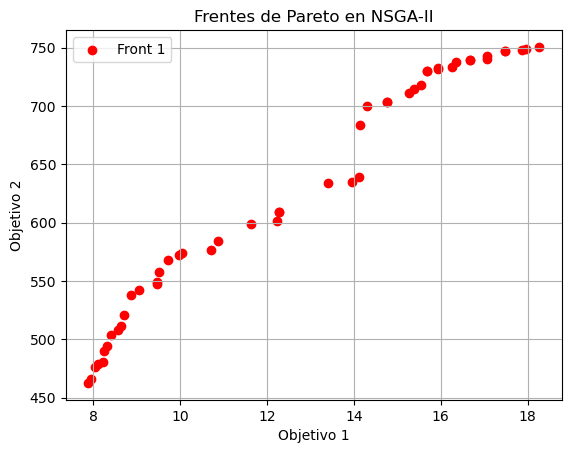

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(7.892836809765324, 462.6696795619648)
(18.268480771811703, 750.6141442614323)
(13.412879044817814, 634.1950823061164)
(14.1449393580093, 683.428114985888)
(12.28339875006718, 608.889359058267)
(12.28339875006718, 608.889359058267)
(11.623097304579694, 598.9356491850874)
(14.121694655841, 639.3157400223942)
(10.878418518182718, 584.6226956082998)
(14.297643023778306, 700.3938407583664)
(10.702788235156655, 576.5277575916347)
(12.222141248844036, 601.2313969095616)
(13.955027989174335, 635.0657400223942)
(10.043315919406957, 573.6764188445029)
(9.049837459405031, 541.8954931134083)
(15.265195722098149, 711.4003338193589)
(14.76627146487298, 703.4717399495835)
(14.76627146487298, 703.4717399495835)
(9.462674810427254, 547.4800083959248)
(15.554783066802123, 718.2128245846772)
(16.26441044434106, 733.6219266860503)
(9.52368782964944, 557.7216534393604)
(17.868480771811704, 747.9296998169877)

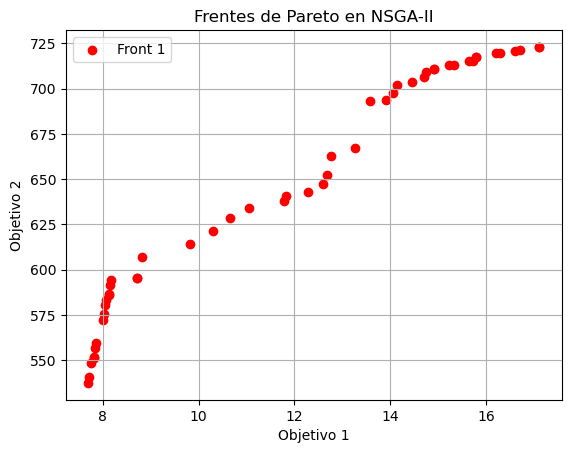

Valores de fitness para los individuos en la primera capa del frente:
funcion pareto front len: 50
(7.707084078961597, 537.356300567455)
(17.10147593272105, 723.0806332083158)
(17.10147593272105, 723.0806332083158)
(13.26336564993814, 666.9943656569552)
(9.83118868727416, 614.3713487834834)
(8.822907202456234, 607.1659917699038)
(13.567258169270556, 693.3955913760581)
(11.047608691888952, 634.2038107364749)
(10.30624829400028, 621.6016360625035)
(10.66599342221958, 628.3101307648822)
(12.760306790177337, 662.8816246218208)
(12.276663696758797, 642.913876272835)
(11.784060330030652, 638.1455809942235)
(12.685013568089108, 652.3356664200334)
(12.58994106594005, 647.1791280803299)
(7.8600329485636715, 559.3754200284156)
(8.017365464242983, 572.2696642600396)
(11.830310402337062, 640.4098811207546)
(14.126263608275993, 701.9986790361145)
(8.71758014727091, 595.1786404566726)
(8.71758014727091, 595.1786404566726)
(13.897777431196465, 693.7225616023735)
(14.052615070651797, 697.597314732067)

KeyboardInterrupt: 

In [ ]:
global which_crossover
global crosspbp
global mutpbp

#mutpbp = 0.2
#crosspbp = 0.5
#which_crossover = 2 # 0 cxOnePoint 1 cxTwoPoint 2 cxUniform 3 aleatorio
pareto_fronts = []

params = []
for i in range(10):

    mutpbp = random.random()
    crosspbp = random.random()
    for h in range(4):
        which_crossover = h
        current_round = i * 4 + h
        params.append(f"mutpbp: {mutpbp} - crosspbp: {crosspbp} - crossover: {which_crossover}")

        print(f"==== INICIO (mutpbp: {mutpbp} - crosspbp: {crosspbp} - crossover: {which_crossover}")
        ini_evolve = time.time()
        the_population = copy.deepcopy(population)
        last_pop_pareto = evolve(the_population, NGEN, current_round)

        end_evolve = time.time()
        print(f"====Tiempo de ejecución evolve: {end_evolve - ini_evolve} segundos")

In [ ]:
# Función para pintar todos los frentes de Pareto en un solo gráfico
def paint_all_paretos(pareto_fronts):
    num_frentes = len(pareto_fronts)

    colores = cm.rainbow(np.linspace(0, 1, num_frentes))

    for i, pareto_front in enumerate(pareto_fronts):
        f1 = [ind.fitness.values[0] for ind in pareto_front]
        f2 = [ind.fitness.values[1] for ind in pareto_front]
        plt.scatter(f1, f2, color=colores[i], label=f'Frente {i+1}')

    plt.xlabel('Internal Density')
    plt.ylabel('Comunity Score')
    plt.title('Comparación de Frentes de Pareto')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Función para pintar cada frente de Pareto en gráficos individuales
def paint_each_pareto(pareto_fronts):
    fronts_size = len(pareto_fronts)
    colors = cm.rainbow(np.linspace(0, 1, NGEN))


    for i, pareto_front in enumerate(pareto_fronts):
        fig, ax = plt.subplots(figsize=(8, 6))
        for ind in pareto_front:
            color = colors[ind.my_gen]
            ax.scatter(ind.fitness.values[0], ind.fitness.values[1], color=color)


        ax.set_title(f'Frente de Pareto {i+1}')
        ax.set_xlabel('Internal Density')
        ax.set_ylabel('Comunity Score')


        sm = plt.cm.ScalarMappable(cmap=cm.rainbow, norm=plt.Normalize(vmin=0, vmax=NGEN))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, orientation='vertical')
        cbar.set_label('Generación')
        cbar.set_ticks(np.linspace(0, NGEN, num=10))
        cbar.set_ticklabels(range(0, NGEN, NGEN // 10))

        plt.show()

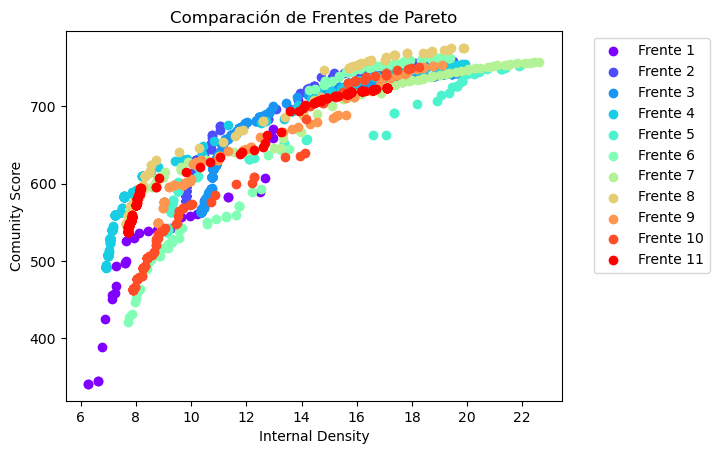

In [ ]:
paint_all_paretos(pareto_fronts)

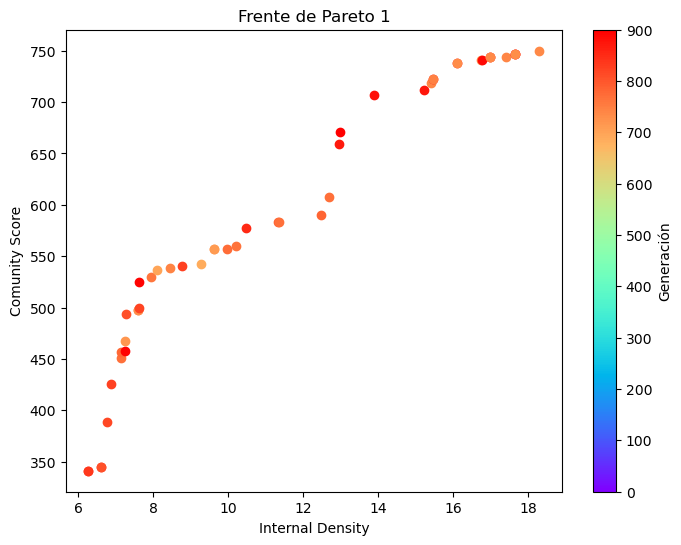

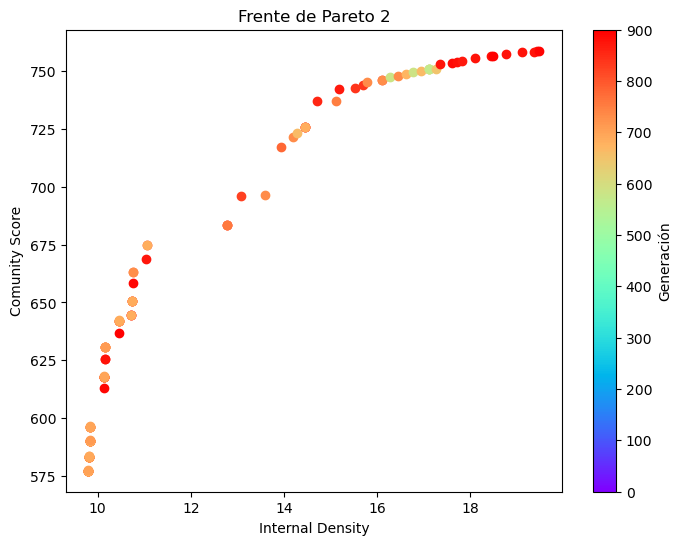

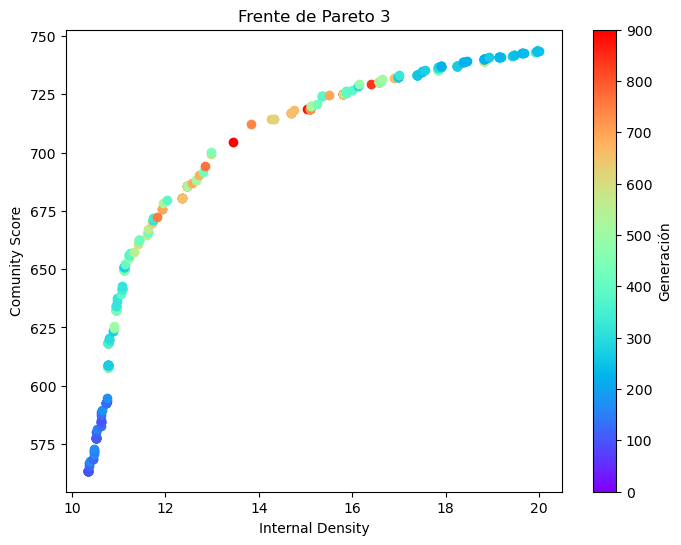

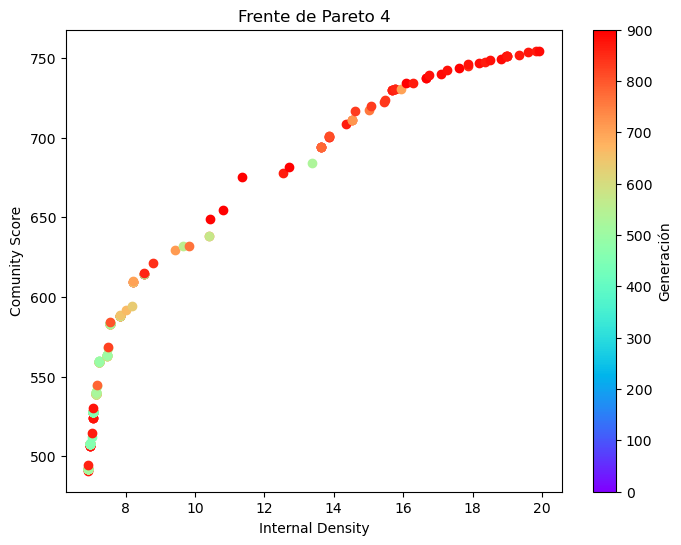

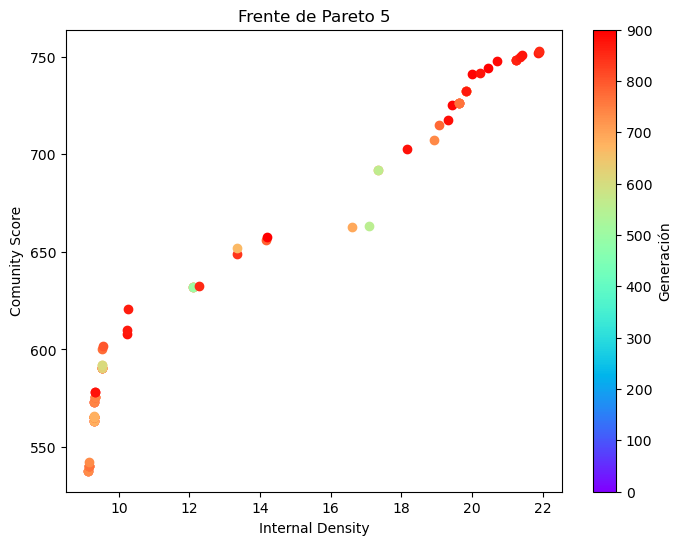

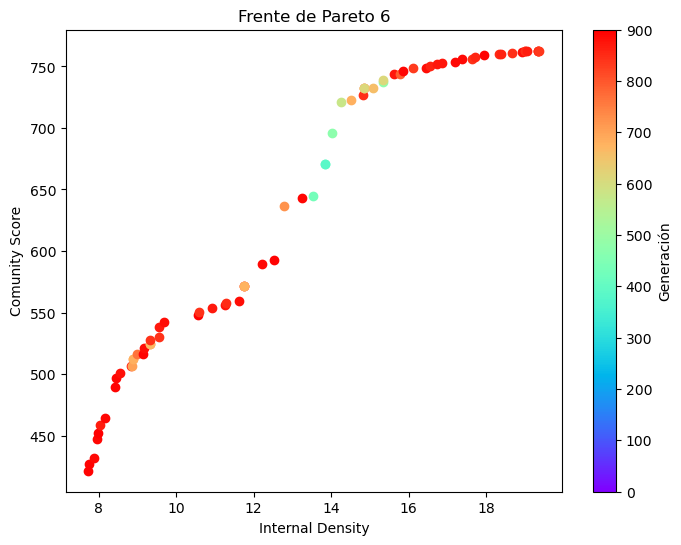

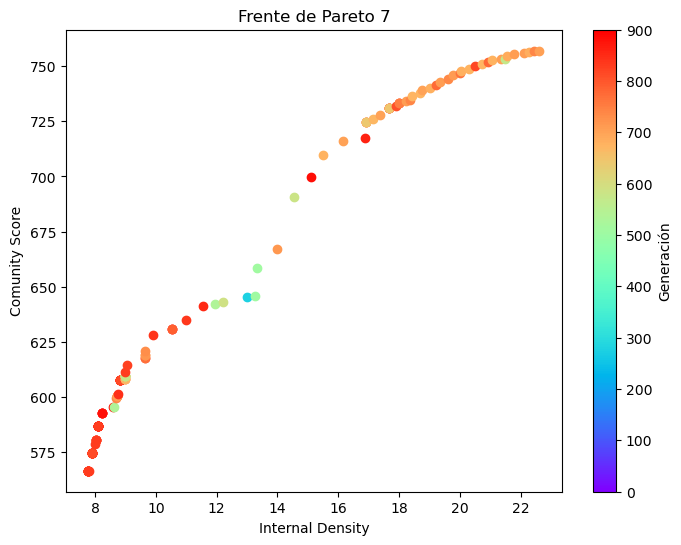

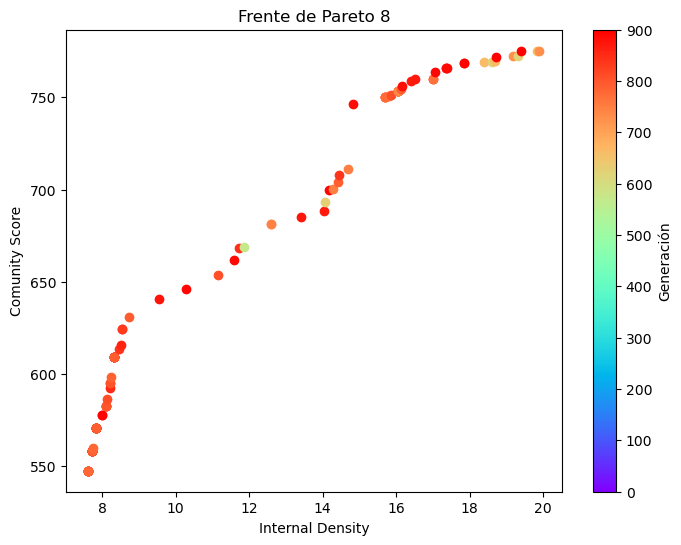

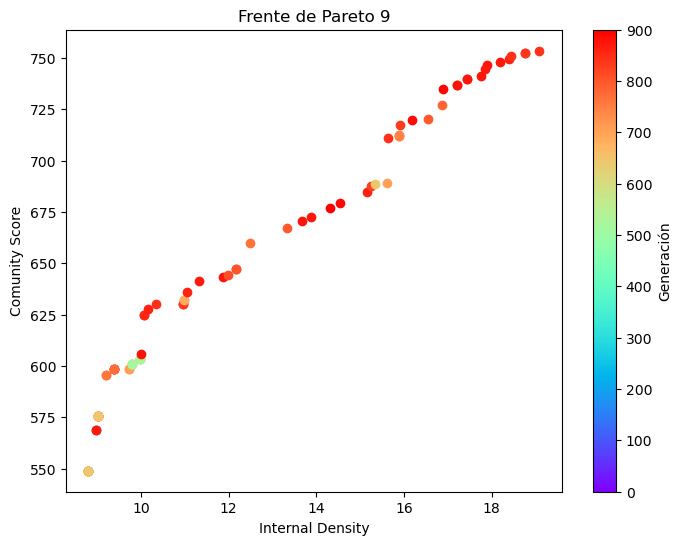

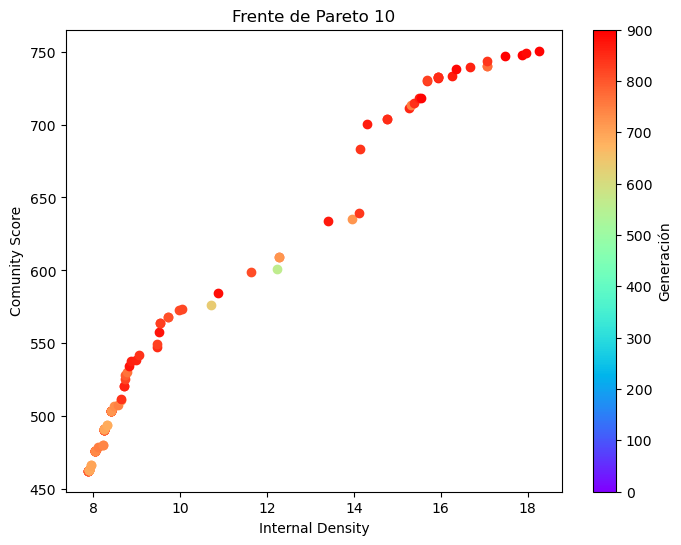

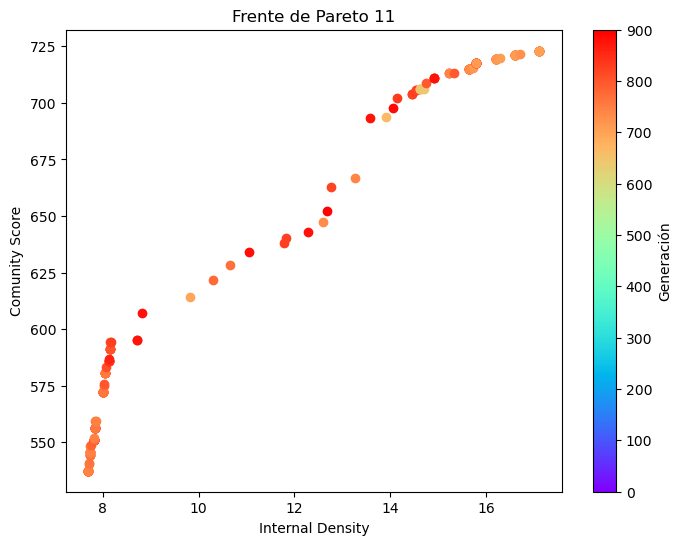

In [ ]:
paint_each_pareto(pareto_fronts)

In [ ]:
def imprimir_solucion(lista_comunidades):
    tamanos_comunidades = [len(comunidad) for comunidad in lista_comunidades]
    df = pd.DataFrame({
        'Comunidad': [f'Comunidad {i+1}' for i in range(len(lista_comunidades))],
        'Número de nodos': tamanos_comunidades
    })
    print(f"Hay {len(lista_comunidades)} comunidades")
    for i, tamano in enumerate(tamanos_comunidades):
        print(f"Comunidad {i+1} tiene {tamano} nodos")
    fig, ax = plt.subplots(figsize=(5, 2))
    ax.axis('tight')
    ax.axis('off')
    ax.table(cellText=df.values, colLabels=df.columns, loc='center')
    plt.show()

In [ ]:
# Función para visualizar un nuevo frente de Pareto coloreado por 'current_round'
def paretos_all_togethers(pareto_fronts):
    rounds = []
    all_togethers = [ind for frente in pareto_fronts for ind in frente]
    new_front = tools.sortNondominated(all_togethers, len(all_togethers), first_front_only=True)[0]
    max_round = max(ind.my_current_round for ind in new_front)
    colors = [
    "red", "blue", "green", "orange", "purple", "cyan",
    "magenta", "lime", "teal", "coral", "navy", "fuchsia",
    "maroon", "olive", "chocolate", "darkgreen", "darkblue",
    "crimson", "darkslateblue", "darkcyan", "darkmagenta",
    "darkolivegreen", "darkorange", "darkorchid", "darkred",
    "darksalmon", "darkseagreen", "darkslategray", "darkturquise",
    "darkviolet", "deepskyblue", "firebrick", "forestgreen",
    "indigo", "midnightblue", "royalblue", "saddlebrown",
    "sienna", "slateblue", "slategray", "steelblue",
    "tomato", "cadetblue"]
    for ind in new_front:
        color = colors[ind.my_current_round]
        rounds.append(ind.my_current_round)
        df_sorted= imprimir_solucion(locus2communities(ind))
        #print(df_sorted)
        #G_encoded = decodificacion_locus_por_indices(ind,node_list)
        #analizar_comunidades_grafo(G_encoded)
        #communities = detect_communities(G_encoded)
        #communities_df = imprimir_comunidades(communities)
        plt.scatter(ind.fitness.values[0], ind.fitness.values[1], color=color)

    plt.xlabel('Objetivo 1')
    plt.ylabel('Objetivo 2')
    plt.title('Nuevo Frente de Pareto Coloreado por current_round')
    plt.show()

    conteo = Counter(rounds)
    for valor, cantidad in conteo.items():
        print(f"El valor {valor} aparece {cantidad} veces.")
        print(f"tiene estos parametros: {params[valor]}")


paretos_all_togethers(pareto_fronts)

In [ ]:
# Función para obtener un nuevo frente de Pareto a partir de una lista de frentes de Pareto
def pareto_of_paretos(pareto_fronts):
    all_togethers =  [ind for frente in pareto_fronts for ind in frente]
    new_front = tools.sortNondominated(all_togethers, len(all_togethers), first_front_only=True)[0]
    return new_front

# Función para visualizar un nuevo frente de Pareto coloreado por 'current_round'
def paretos_all_togethers(pareto_fronts):
    rounds = []
    new_front = pareto_of_paretos(pareto_fronts)
    max_round = max(ind.my_current_round for ind in new_front)
    colors = [
    "red", "blue", "green", "orange", "purple", "cyan",
    "magenta", "lime", "teal", "coral", "navy", "fuchsia",
    "maroon", "olive", "chocolate", "darkgreen", "darkblue",
    "crimson", "darkslateblue", "darkcyan", "darkmagenta",
    "darkolivegreen", "darkorange", "darkorchid", "darkred",
    "darksalmon", "darkseagreen", "darkslategray", "darkturquoise",
    "darkviolet", "deepskyblue", "firebrick", "forestgreen",
    "indigo", "midnightblue", "royalblue", "saddlebrown",
    "sienna", "slateblue", "slategray", "steelblue",
    "tomato", "cadetblue"]
    for ind in new_front:
        color = colors[ind.my_current_round]
        rounds.append(ind.my_current_round)
        plt.scatter(ind.fitness.values[0], ind.fitness.values[1], color=color)
    plt.xlabel('Objetivo 1')
    plt.ylabel('Objetivo 2')
    plt.title('Nuevo Frente de Pareto Coloreado por current_round')
    plt.show()

    conteo = Counter(rounds)
    for valor, cantidad in conteo.items():
        print(f"La configuración #{valor} aporta {cantidad} individuos.")
        print(f"tiene estos parametros: {params[valor]}")

    for ind in new_front:
        df_sorted= imprimir_solucion(locus2communities(ind))


paretos_all_togethers(pareto_fronts)